In [1]:
!pip install gpytorch
!pip install torchbnn
import gpytorch
import os
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") 
import time 
import random
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process as gp 
from sklearn.gaussian_process.kernels import DotProduct as lin, WhiteKernel, RBF, ConstantKernel, RBF, WhiteKernel, RationalQuadratic, Exponentiation
import matplotlib.pyplot as plt

     |████████████████████████████████| 498 kB 8.2 MB/s 


In [2]:
import torch
from torch._C import device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms

In [3]:
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood, MultitaskGaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL 

In [4]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


## Deep-GP FOR DUAL OUTPUT ON Non_LINEAR_ERROR_1.CSV


In [49]:
df_1 = pd.read_csv('drive/MyDrive/Auto/Data/Non_Linear/non_linear_error_1.csv')
drop = ['time_step_H'] 

for j in df_1.columns:
  if len(j) >= 7 and j[:7] == 'Unnamed':
    df_1.drop(j, axis = 1, inplace =True)

for i in drop:
  df_1.drop(i, axis = 1, inplace = True)


In [50]:
df_1

,time_step_A,theta_H,theta_A,H_spring,A_spring,H_damp,A_damp,H_mass,A_mass,disp_sw,disp_s,vel_sw,vel_s,acc_sw,acc_s,error_1,error_2
0,0.00,0.000000,1.000000,1.985727,7.588243,0.135539,0.129445,0.009439,0.007430,0.000000e+00,0.000000,0.000000,0.000000,0.002706,3.502266,0.000998,198.163232
1,0.01,0.001000,1.000000,1.985727,7.588243,0.135539,0.129445,0.009439,0.007430,1.355734e-07,0.000175,0.000027,0.035004,0.003136,3.498148,0.002164,198.109886
2,0.02,0.002000,0.999998,1.985727,7.588243,0.135539,0.129445,0.009439,0.007430,5.658690e-07,0.000700,0.000059,0.069957,0.003636,3.492086,0.003330,197.952367
3,0.03,0.003000,0.999996,1.985727,7.588243,0.135539,0.129445,0.009439,0.007430,1.341084e-06,0.001574,0.000096,0.104839,0.004206,3.484085,0.004496,197.690856
4,0.04,0.004000,0.999992,1.985727,7.588243,0.135539,0.129445,0.009439,0.007430,2.517159e-06,0.002796,0.000139,0.139632,0.004844,3.474151,0.005660,197.325593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,999.96,-0.509811,0.860287,4.941571,5.502668,0.192829,0.172911,0.005425,0.006072,-3.364030e-01,0.506717,0.069210,0.036365,-0.002107,-0.005200,-4.009084,7.451680
99997,999.97,-0.508950,0.860796,4.941571,5.502668,0.192829,0.172911,0.005425,0.006072,-3.357110e-01,0.507080,0.069186,0.036306,-0.002003,-0.005190,-4.005187,7.449028
99998,999.98,-0.508089,0.861304,4.941571,5.502668,0.192829,0.172911,0.005425,0.006072,-3.350193e-01,0.507443,0.069162,0.036248,-0.001899,-0.005179,-4.001271,7.446377
99999,999.99,-0.507228,0.861812,4.941571,5.502668,0.192829,0.172911,0.005425,0.006072,-3.343278e-01,0.507805,0.069139,0.036190,-0.001794,-0.005168,-3.997339,7.443727


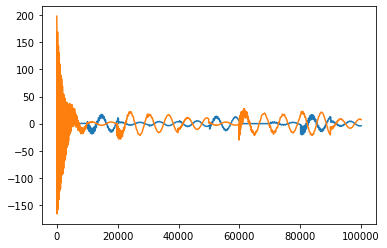

In [51]:
plt.plot(df_1['error_1']) 
plt.plot(df_1['error_2']) 

In [52]:
k = len(df_1)//100 * (80)
Batch_size = 512

ss = StandardScaler()

X = torch.from_numpy(ss.fit_transform(df_1.iloc[:k, :-2])).float().to(device)  #train X
Y = torch.from_numpy( df_1.iloc[:k, -2:].to_numpy() ).float().to(device) #test Y
dataset = TensorDataset(X, Y)

Test_X = torch.from_numpy(ss.fit_transform(df_1.iloc[k:, :-2])).float().to(device)
Test_Y = torch.from_numpy( df_1.iloc[k:, -2:].to_numpy() ).float().to(device)
Test_dataset = TensorDataset(Test_X, Test_Y)

data_loader = DataLoader(dataset, batch_size=Batch_size, shuffle = False) 
test_data_loader = DataLoader(Test_dataset, batch_size=Batch_size, shuffle= False)


In [53]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs))) 

In [54]:
num_hidden_dgp_dims = 3 # 2 if smoke_test else 10
num_tasks = 2

class MultiTaskDeepGP(DeepGP):
    def __init__(self, train_x_shape):
        
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dgp_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=num_tasks,
            mean_type='constant',
        )

        super().__init__() 

        self.hidden_layer = hidden_layer 
        self.last_layer = last_layer 
        self.likelihood = MultitaskGaussianLikelihood(num_tasks = num_tasks)

    def forward(self, inputs): 
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            
            #lls = []
            
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                #lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1)#, torch.cat(lls, dim=-1) 

# Training

In [55]:
import tqdm 

model = MultiTaskDeepGP(X.shape)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)

mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data = X.size(0))) 

epochs = 100
num_samples = 5
epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")

model = model.cuda()

total_loss = []
for i in epoch_iter:
  minibatch_iter = tqdm.notebook.tqdm(data_loader, desc='Minibatch', leave=False)
  loss_epoch_list = []
  for x_batch, y_batch in minibatch_iter:
    with gpytorch.settings.num_likelihood_samples(num_samples):
      optimizer.zero_grad()
      output = model(x_batch)
      loss = -mll(output, y_batch)

      loss.backward()
      optimizer.step()
      
      loss_epoch_list.append(loss.item())

      minibatch_iter.set_postfix(loss=loss.item())

  total_loss.append(np.mean(loss_epoch_list)) 

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/157 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Non_Linear_Avg_marginal_likelihood_per_epoch')

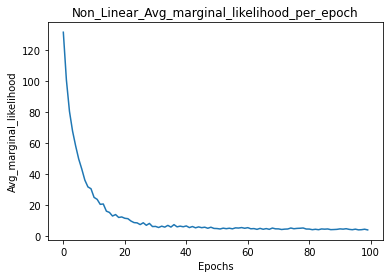

In [57]:
plt.plot(total_loss)
plt.xlabel('Epochs') 
plt.ylabel('Avg_marginal_likelihood')
plt.title('Non_Linear_Avg_marginal_likelihood_per_epoch')
#plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_Linear/Avg_marginal_likelihood_per_epoch_non_linear_error_csv_1.png')

# Inference

In [79]:
model.eval()
i = 0
mu = []
var = []
with torch.no_grad():
  for X, y in test_data_loader:
    preds = model.likelihood(model(X)).to_data_independent_dist()
    mu.append(preds.mean.mean(0))
    var.append(preds.variance.mean(0))

  prediction = torch.cat(mu, dim = 0).cpu()
  variance = torch.cat(var, dim = 0).cpu()

confidence = 1.96 * np.sqrt(variance) 


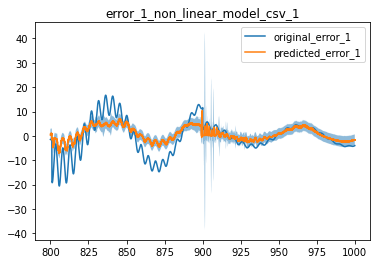

In [69]:
plt.title('error_1_non_linear_model_csv_1')
plt.plot(df_1.loc[k:,'time_step_A'].values, df_1.iloc[k:, -2:-1], label = 'original_error_1') 
plt.plot(df_1.loc[k:, 'time_step_A'].values, prediction[:,0], label='predicted_error_1' )
plt.fill_between(df_1.loc[k:, 'time_step_A'].values, prediction[:,0] + confidence[:, 0], prediction[:,0] - confidence[:, 0], alpha=0.5)
plt.legend()
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_Linear/error_1_non_linear_model_csv_1.png')

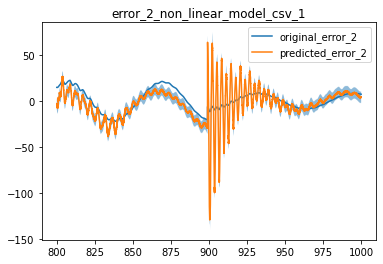

In [86]:
plt.title('error_2_non_linear_model_csv_1')
plt.plot(df_1.loc[k:,'time_step_A'].values, df_1.iloc[k:, -1:], label = 'original_error_2') 
plt.plot(df_1.loc[k:, 'time_step_A'].values, prediction[:, 1], label='predicted_error_2' )
plt.fill_between(df_1.loc[k:, 'time_step_A'].values, prediction[:, 1] + confidence[:, 1], prediction[:, 1] - confidence[:, 1], alpha=0.5)
plt.legend()
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_Linear/error_2_non_linear_model_csv_1.png') 

In [71]:
torch.save(model.state_dict(), 'drive/MyDrive/Auto/DEEP_GP/Non_Linear/NonLinear_MultiTaskDeepGp_csv_1.pth') 

# Try on test data

In [61]:
df = pd.read_csv('drive/MyDrive/Auto/Data/Non_Linear_Test/Non_Test_data_1.csv')
drop = ['time_step_H'] 

for j in df.columns:
  if len(j) >= 7 and j[:7] == 'Unnamed':
    df.drop(j, axis = 1, inplace =True)


df.drop('time_step_H', axis = 1, inplace = True)

Batch_size = 256

ss = StandardScaler()

X = torch.from_numpy(ss.fit_transform(df.iloc[:, :-2])).float().to(device)  #train X
Y = torch.from_numpy( df.iloc[:, -2:].to_numpy() ).float().to(device) #test Y
dataset = TensorDataset(X, Y)

data_loader = DataLoader(dataset, batch_size=Batch_size, shuffle = False) 


In [72]:
state_dict = torch.load('drive/MyDrive/Auto/DEEP_GP/Non_Linear/NonLinear_MultiTaskDeepGp_csv_1.pth') 

model.load_state_dict(state_dict)


<All keys matched successfully>

In [73]:

model.eval() 

MultiTaskDeepGP(
  (hidden_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): LinearMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (last_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )


In [74]:
mu = []
var = []
with torch.no_grad():
  for X, y in data_loader:
    preds = model.likelihood(model(X)).to_data_independent_dist()
    mu.append(preds.mean.mean(0))
    var.append(preds.variance.mean(0))

  prediction = torch.cat(mu, dim = 0).cpu()
  variance = torch.cat(var, dim = 0).cpu()

confidence = 1.96 * np.sqrt(variance) 


In [75]:
len(prediction[:,0]), len(df.loc[:, 'time_step_A'].values) 

(9001, 9001)

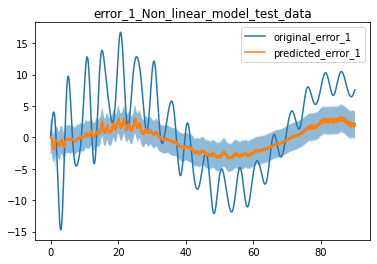

In [76]:
plt.title('error_1_Non_linear_model_test_data')
plt.plot(df.loc[:,'time_step_A'].values, df.iloc[:, -2:-1], label = 'original_error_1') 
plt.plot(df.loc[:, 'time_step_A'].values, prediction[:,0], label='predicted_error_1' )
plt.fill_between(df.loc[:, 'time_step_A'].values, prediction[:,0] + confidence[:, 0], prediction[:,0] - confidence[:, 0], alpha=0.5)
plt.legend() 
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_Linear/error_1_Non_linear_model_test_data.png')

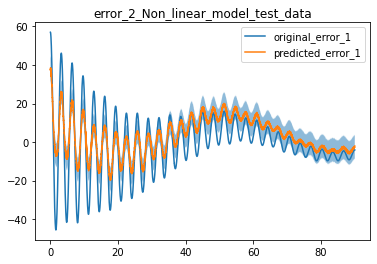

In [77]:
plt.title('error_2_Non_linear_model_test_data')
plt.plot(df.loc[:,'time_step_A'].values, df.iloc[:, -1], label = 'original_error_1') 
plt.plot(df.loc[:, 'time_step_A'].values, prediction[:, 1], label='predicted_error_1' )
plt.fill_between(df.loc[:, 'time_step_A'].values, prediction[:,1] + confidence[:, 1], prediction[:, 1] - confidence[:, 1], alpha=0.5)
plt.legend() 
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_Linear/error_2_Non_linear_model_test_data.png')  